In [1]:
%matplotlib inline


In [2]:
#export
from exp.nb_05 import *

In [3]:
#export
def normalizeVectors(xTrainingVector, xValidationVector):
    return vectorNormalization(xTrainingVector), vectorNormalization(xValidationVector
                                                                    )
def vectorNormalization(vector):
    return normalizeVector(vector, vector.mean(), vector.std())

In [29]:
xTraining, yTraining, xValidation, yValidation =getMnistData()
xTrainingNormalized, xValidationNormalized = normalizeVectors(xTraining, xValidation)

SyntaxError: invalid syntax (<ipython-input-29-fc0ec6a11ee1>, line 2)

Verify normalization was done correctly

In [5]:
xTrainingNormalized.mean(), xTrainingNormalized.std()

(tensor(0.0001), tensor(1.))

In [6]:
xValidationNormalized.mean(), xValidationNormalized.std()

(tensor(-4.2248e-06), tensor(1.))

## \o/
Both means are near zero and the standard deviation is near one!

In [30]:
trainingDataSet = Dataset(xTraining.cuda(), yTraining.cuda())
validationDataSet = Dataset(xValidation.cuda(), yValidation.cuda())

In [31]:
sizeOfHiddenLayer = 50
batchSize = 64
numberOfClasses = yTraining.max().item() + 1

In [32]:
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)

In [10]:
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader,numberOfClasses)

In [33]:
imageDataBunch.numberOfClasses

10

In [34]:
#export
class LambdaLayer(torch.nn.Module):
    def __init__(self, fundie):
        super().__init__()
        self.fundie = fundie
        
    def forward(self, inputVector):
        return self.fundie(inputVector)
    
def flattenImage(imageMatrix): return imageMatrix.view(imageMatrix.shape[0], -1)

In [35]:
def resizeImage(imageVector): return imageVector.view(-1, 1, 28, 28)

In [36]:
def createConvolutionModel(numberOfClasses):
    return torch.nn.Sequential(
        LambdaLayer(resizeImage),
        torch.nn.Conv2d(1, 8, 5, 2, 2), torch.nn.ReLU(), 
        torch.nn.Conv2d(8, 16, 3, 2, 1), torch.nn.ReLU(), 
        torch.nn.Conv2d(16, 32, 3, 2, 1), torch.nn.ReLU(), 
        torch.nn.Conv2d(32, 32, 3, 2, 1), torch.nn.ReLU(), 
        torch.nn.AdaptiveAvgPool2d(1),
        LambdaLayer(flattenImage),
        torch.nn.Linear(32, numberOfClasses)
    ).cuda()

In [37]:
convolutionModel = createConvolutionModel(numberOfClasses)
convolutionModel

Sequential(
  (0): LambdaLayer()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): LambdaLayer()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [38]:
class Teacher():
    
    def __init__(self, 
                 lossFunction=Functional.cross_entropy, 
                 accuracyFunction=accuracy,
                 schedulingFunctions=[cosineScheduler(1e-1,1e-6), cosineScheduler(1e-1,1e-6)]
                ):
        self.lossFunction = lossFunction
        self.accuracyFunction = accuracyFunction
        self.schedulingFunctions = schedulingFunctions
        self._initStorage()

    def _initStorage(self):
        self.learningRates, self.losses = [],[]
        
    def teachModel(self, cnnModel, dataBunch, numberOfEpochs):
        self.optimizer = optim.SGD(cnnModel.parameters(), self.schedulingFunctions[0](0))
        self.numberOfEpochs = numberOfEpochs
        self._beginTraining()
        for epoch in range(numberOfEpochs):
            self.epoch = epoch
            trainingLoss, trainingAccuracy = self._trainModel(cnnModel, dataBunch.trainingDataLoader)
            print("Epoch #{} Training: Loss {} Accuracy {}".format(epoch, trainingLoss, trainingAccuracy))
            
            validationLoss, validationAccuracy = self._validateModel(cnnModel, dataBunch.validationDataLoader)
            print("Epoch #{} Validation: Loss {} Accuracy {}".format(epoch, validationLoss, validationAccuracy))
            print("")
            
    def plotLearningRates  (self): plotter.plot(self.learningRates)
        
    def plotLosses(self): plotter.plot(self.losses)
            
    def _beginTraining(self):
        self._initStorage()
            
    def _anealLearningRate(self):
        for parameterGroup, schedulingFunction in zip(self.optimizer.param_groups,self.schedulingFunctions):
            scheduledLearningRate = schedulingFunction(self.epoch/self.numberOfEpochs)
            parameterGroup['lr'] = scheduledLearningRate
            
    def _trainModel(self, cnnModel, trainingDataSet):
        def _teachModel(loss):
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            #capture metrics
            self.learningRates.append(self.optimizer.param_groups[-1]['lr'])
            self.losses.append(loss.detach().cpu())
            
        returnItems = self._proccessDataSet(cnnModel, trainingDataSet, self._anealLearningRate, _teachModel)
        return returnItems
        
    def _validateModel(self, cnnModel, validationDataSet):
        with torch.no_grad():
            returnItems = self._proccessDataSet(cnnModel, validationDataSet, self._anealLearningRate)
        return returnItems
    
    def _proccessDataSet(self, 
                         cnnModel, 
                         dataLoader, 
                         preEvaluation=lambda: None,
                         postEvaluation=lambda loss: None):
        accumulatedLoss, accumulatedAccuracy = 0.,0.
        for _xDataSet, _yDataSet in dataLoader:
            preEvaluation()
            _predictions = cnnModel(_xDataSet)
            loss = self.lossFunction(_predictions, _yDataSet)
            postEvaluation(loss)
            accumulatedLoss+= loss
            accumulatedAccuracy += self.accuracyFunction(_predictions, _yDataSet)
        numberOfBatches = len(dataLoader)
        return accumulatedLoss/numberOfBatches, accumulatedAccuracy/numberOfBatches

In [39]:
phases = [0.3, 0.7]
weightsScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.3, 0.6, 0.2)) 
biasScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.9, 1.8, 0.6))

In [40]:
steps = torch.arange(0, 100)
inputSpace = torch.linspace(0.01,1,100)

In [41]:
#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

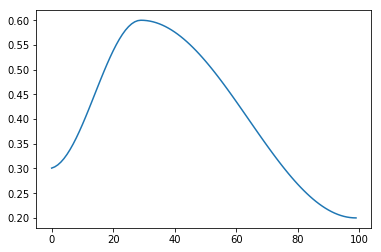

In [42]:
plotter.plot(steps, [weightsScheduler(o) for o in inputSpace])

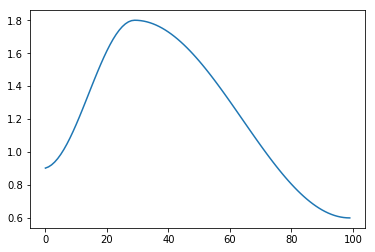

In [43]:
plotter.plot(steps, [biasScheduler(o) for o in inputSpace])

In [44]:
teacher = Teacher(schedulingFunctions=[weightsScheduler, biasScheduler])

In [45]:
%time teacher.teachModel(convolutionModel, imageDataBunch, 3)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same